In [1]:
# warnings
import warnings
warnings.filterwarnings("ignore")

# Basic imports
import numpy as np
import pandas as pd
import tqdm

# spacy
import spacy

#gensim
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import TfidfModel
from gensim.models import CoherenceModel

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\matlab\mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Progra

# New dataset built from scrapping linkedin profiles

In [2]:
database = 'output_linkedin_cle'

In [3]:
df = pd.read_csv(f'../{database}.csv', sep=";")
df.columns = ['Name', 'Location', 'Title', 'About', 'URL']
df = df.fillna('')
df['Title+About'] = df['Title'] + ' ' + df['About']
data = list(df['Title+About'])

In [4]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    return [" ".join([token.lemma_ for token in nlp(text) if token.pos_ in allowed_postags]) for text in texts]

lemmatized_texts = lemmatization(data)

In [5]:
def gen_words(texts):
    return [gensim.utils.simple_preprocess(text, deacc=True) for text in texts]

data_words = gen_words(lemmatized_texts)

In [6]:
#BIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=50)

bigram = gensim.models.phrases.Phraser(bigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

data_bigrams = make_bigrams(data_words)
data_bigrams = [t for t in data_bigrams if t != []] # remove empty documents

In [7]:
#DF FILTER
id2word = corpora.Dictionary(data_bigrams)
texts = data_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value=0.4
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    tfidf_ids = [id for id,value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    hfreq_words = [id for id in bow_ids if tfidf.dfs[id]/len(corpus) > low_value]
    drops = hfreq_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in hfreq_words and b[0] not in words_missing_in_tfidf]       
    corpus[i] = new_bow

In [8]:
#TF-IDF FILTER
id2word = corpora.Dictionary(data_bigrams)
texts = data_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value=0.02
words = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]       
    corpus[i] = new_bow

In [9]:
def get_lda_model(corpus, id2word, K, a='symmetric', b='auto'):
    
    '''
    This function checks whether a certain combination of hyperparameters
    is already saved in the repository, if the model is found it is loaded and 
    returned for this function. If not, a model is trained with the combination 
    of parameters and saves it to the repository.
    '''
    
    global database
    
    path = f'models/{database}_lda_model_{K}_topics_{a}_alpha_{b}_beta'

    try:
        lda_model = gensim.models.LdaModel.load(path)

    except FileNotFoundError:
        lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=K,
                                            random_state=100,
                                            chunksize=100,
                                            passes=10,
                                            alpha=a,
                                            eta=b)
        lda_model.save(path)
        
    return lda_model

In [10]:
def compute_coherence_values(corpus, lemmatized_texts, id2word, K, coherence_method = 'u_mass', a='symmetric', b='auto'):
    
    '''
    This function computes the coherence value for a specific metric in a specific combination of
    hyperparameters of the LDA model.
    '''
    
    lda_model = get_lda_model(corpus, id2word, K, a, b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, texts=lemmatized_texts, coherence=coherence_method)
    
    return coherence_model_lda.get_coherence()

In [11]:
def line_plot_dict(dictionary, title, x_label, y_label, x_logscale=False, y_logscale=False):
    
    '''
    This function plots the coherence values for different K number of topics and adds a red line
    in local maxima in order to help in the K parameter value selection.
    '''
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    ax.plot(list(dictionary.keys()), list(dictionary.values()))
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_logscale:
        ax.set_xscale('log')
    if y_logscale:
        ax.set_yscale('log')
    
    from scipy.signal import argrelextrema

    # Add vertical line and xtick on the local maximas
    local_maximas = argrelextrema(np.array(list(dictionary.values())), np.greater)
    for i in local_maximas[0]:
        ax.axvline(list(dictionary.keys())[i], color='red', linestyle='--', alpha=0.5)
        ax.text(list(dictionary.keys())[i], list(dictionary.values())[i], str(list(dictionary.keys())[i]), rotation=0, fontsize=10)

    plt.show()

In [12]:
def hyperparameter_selection(method='u_mass'):
    # Topics range
    min_topics = 2
    max_topics = 40
    step_size = 1
    topics_range = range(min_topics, max_topics + 1, step_size)
    num_of_docs = len(corpus)

    model_results = {}
    pbar = tqdm.tqdm(total= (max_topics - min_topics + 1))
    for K in topics_range:
        # get the coherence score for the given parameters
        model_results[K] = compute_coherence_values(corpus, data_bigrams, id2word, K, method)
        pbar.update(1)

    pbar.close()  
    line_plot_dict(model_results, f"{method} N_Topics x Coherence", "N_Topics", "Coherence Score")
    return sorted(model_results.items(), key=lambda kv: kv[1], reverse=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.56it/s]


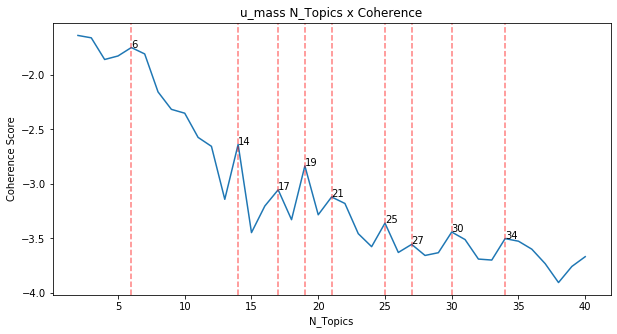

[(2, -1.6371486001057312),
 (3, -1.6589632938548764),
 (6, -1.7480533682550068),
 (7, -1.80670267589399),
 (5, -1.8255299197081984),
 (4, -1.8577399112272674),
 (8, -2.1551654206425006),
 (9, -2.3151203423238242),
 (10, -2.350487054513704),
 (11, -2.572404353200979),
 (14, -2.637001337114527),
 (12, -2.654338302054859),
 (19, -2.833901441246391),
 (17, -3.0532232126057544),
 (21, -3.1191071962757335),
 (13, -3.140554580173069),
 (22, -3.1786485505579636),
 (16, -3.201994994863708),
 (20, -3.2825132459657995),
 (18, -3.3273847190948267),
 (25, -3.3588159989298503),
 (30, -3.4408203039682586),
 (15, -3.4460329871160935),
 (23, -3.4557190612171413),
 (34, -3.5010121097009246),
 (31, -3.5097771954042796),
 (35, -3.524792478726855),
 (27, -3.5537640505748254),
 (24, -3.575000505392881),
 (36, -3.597972538215501),
 (26, -3.6281650507939087),
 (29, -3.630432375495599),
 (28, -3.655560782993298),
 (40, -3.666889419621839),
 (32, -3.6887907279271883),
 (33, -3.6978159945918563),
 (37, -3.730653

In [13]:
hyperparameter_selection('u_mass')

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [10:34<00:00, 16.27s/it]


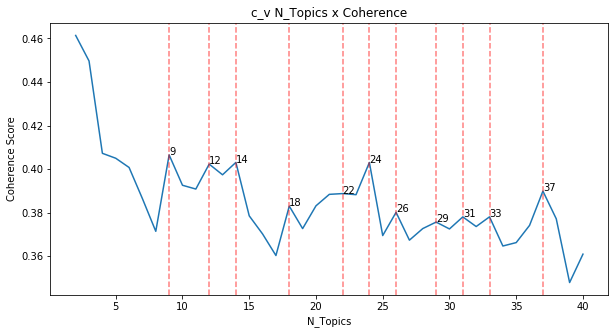

[(2, 0.46137592208581957),
 (3, 0.44965565997456247),
 (4, 0.40727360007445906),
 (9, 0.4065496029368847),
 (5, 0.4050110518654685),
 (14, 0.4031051403040146),
 (24, 0.4030742909231389),
 (12, 0.4023188641727517),
 (6, 0.4007735793278142),
 (13, 0.3974199587161658),
 (10, 0.3926094820056817),
 (11, 0.390876550307066),
 (37, 0.38992236343823394),
 (22, 0.38879665354450793),
 (21, 0.3884408034209426),
 (23, 0.388289614660902),
 (7, 0.38646233985179085),
 (20, 0.38317624625265384),
 (18, 0.38303445891803034),
 (26, 0.3801853599157989),
 (15, 0.37857626486838564),
 (33, 0.37811238109844036),
 (31, 0.3780911003681745),
 (38, 0.37720564403472545),
 (29, 0.3757127277975737),
 (36, 0.37419824716578326),
 (32, 0.37366736685531465),
 (28, 0.3727309305757204),
 (19, 0.37272113203085516),
 (30, 0.37256188169791127),
 (8, 0.3714720194428156),
 (16, 0.3702599679929946),
 (25, 0.369523783758711),
 (27, 0.36741568797726126),
 (35, 0.36629924196557034),
 (34, 0.3647290815807276),
 (40, 0.36099345631065

In [14]:
hyperparameter_selection('c_v')

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [08:41<00:00, 13.38s/it]


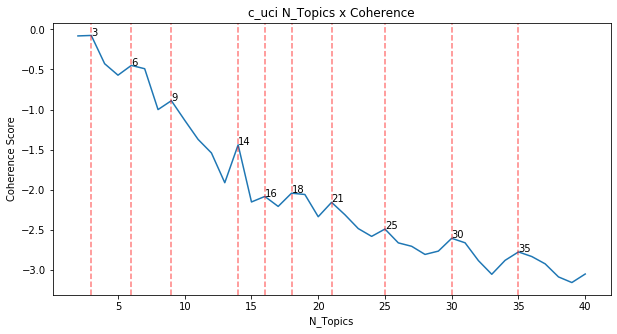

[(3, -0.07495443707771265),
 (2, -0.08089589263727673),
 (4, -0.42779217976876205),
 (6, -0.4490979598981335),
 (7, -0.4905499701306688),
 (5, -0.5711572523374453),
 (9, -0.8896272222629238),
 (8, -1.000696404274032),
 (10, -1.134743904069375),
 (11, -1.3727123129181327),
 (14, -1.4409849561955075),
 (12, -1.5422257163876527),
 (13, -1.9139436291572223),
 (18, -2.044668470144166),
 (19, -2.0609244351191918),
 (16, -2.0853838513060348),
 (15, -2.1543997186570967),
 (21, -2.1591281130338738),
 (17, -2.2100205345102384),
 (22, -2.3139851407526306),
 (20, -2.338682766072396),
 (23, -2.4868683418751827),
 (25, -2.492484612648074),
 (24, -2.5840545397767962),
 (30, -2.6080008366823413),
 (31, -2.664282293286166),
 (26, -2.665242709434392),
 (27, -2.7080075934206183),
 (29, -2.7680716779844214),
 (35, -2.778253910213207),
 (28, -2.809524958382705),
 (36, -2.835899598241978),
 (34, -2.8832063416050464),
 (32, -2.886824588209211),
 (37, -2.9271757577065127),
 (40, -3.05414248840764),
 (33, -3.0

In [15]:
hyperparameter_selection('c_uci')

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [08:57<00:00, 13.77s/it]


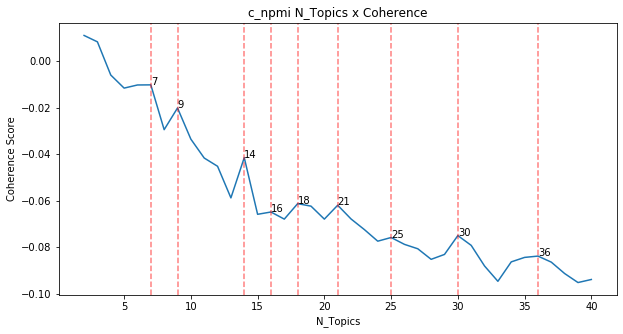

[(2, 0.011003533023077196),
 (3, 0.008252917953416686),
 (4, -0.006016168602430635),
 (7, -0.010241217851332154),
 (6, -0.01029116366156812),
 (5, -0.0116380174395385),
 (9, -0.020185053697679874),
 (8, -0.029504834172029905),
 (10, -0.033577168322306755),
 (14, -0.041531524969798624),
 (11, -0.041693720654207976),
 (12, -0.04524480501218697),
 (13, -0.058834213387821285),
 (18, -0.06131581445927671),
 (21, -0.06198568481187874),
 (19, -0.06238468763137235),
 (16, -0.06490523309104648),
 (15, -0.06589300206271807),
 (22, -0.0679023710396869),
 (17, -0.06796052629916229),
 (20, -0.06796484075739195),
 (23, -0.07247117810774353),
 (30, -0.07503818825582272),
 (25, -0.07586782725629285),
 (24, -0.0774502699038383),
 (26, -0.0788169786209487),
 (31, -0.07924756524530327),
 (27, -0.08071149149683512),
 (29, -0.08314620732626674),
 (36, -0.08386069513683464),
 (35, -0.08442559814351755),
 (28, -0.08525313642262367),
 (34, -0.08634908884216538),
 (37, -0.08645922016890471),
 (32, -0.088112696

In [16]:
hyperparameter_selection('c_npmi')

# Visualization for the K topics chosen as the "best fit"

In [17]:
K = 9
lda_model = get_lda_model(corpus, id2word, K)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=K)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.010365  0.100240       1        1  21.419543
8      0.127291  0.064247       2        1  15.670452
2     -0.129129  0.111704       3        1  11.161985
0      0.027054 -0.166853       4        1  10.360918
1      0.047475  0.173746       5        1   9.969770
7     -0.141207 -0.147812       6        1   9.945691
5     -0.136908 -0.011223       7        1   8.640511
4      0.024586 -0.035701       8        1   8.398262
3      0.191202 -0.088347       9        1   4.432865, topic_info=             Term        Freq       Total Category  logprob  loglift
34           cell   77.000000   77.000000  Default   9.0000   9.0000
376        policy   89.000000   89.000000  Default   8.0000   8.0000
36    development  222.000000  222.000000  Default   7.0000   7.0000
69          datum  311.000000  311.000000  Default   6.0000   6.0000
259  quantitative  184.000000  184.000000  Default   5.0000   5.0000
..            ...         ...         ...      ...      ...      ...
29     experience   15.306945  635.455020   Topic9  -4.7695  -0.6099
145          such    8.868661   74.988187   Topic9  -5.3152   0.9813
25          focus    9.436535  207.240283   Topic9  -5.2532   0.0268
19            use    9.486319  228.960687   Topic9  -5.2479  -0.0676
9        research    9.678540  654.074814   Topic9  -5.2279  -1.0972

[238 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
1262      4  0.887140         additionally
1406      4  0.887264               affair
576       1  0.814676  algorithmic_trading
576       2  0.045260  algorithmic_trading
576       3  0.045260  algorithmic_trading
...     ...       ...                  ...
2522      6  0.148532                youth
2522      7  0.148532                youth
2522      8  0.668394                youth
2080      2  0.782433                   yr
2080      9  0.156487                   yr

[726 rows x 3 columns], R=9, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 3, 1, 2, 8, 6, 5, 4])